In [ ]:
!pip install pyclipper

In [116]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread_collection, imsave, imshow, imread, imshow_collection
from skimage.feature import match_descriptors, ORB
from skimage.feature import corner_harris, corner_peaks, corner_fast, corner_subpix, corner_foerstner
from skimage.transform import warp, AffineTransform
from skimage.measure import ransac
from imageio import mimread
from skimage.color import rgb2gray
import cv2
from skimage.feature import canny
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from skimage.measure import label as sk_label
from skimage.morphology import binary_opening, binary_closing
from skimage.filters import threshold_otsu, threshold_local, threshold_triangle
import pyclipper
import pandas as pd

In [20]:
template_names = np.array(['pallete', 'shadow', 'coin', 'glasses', 'cat', 'pen', 'earing',
                           'scissors', 'frog', 'book'])

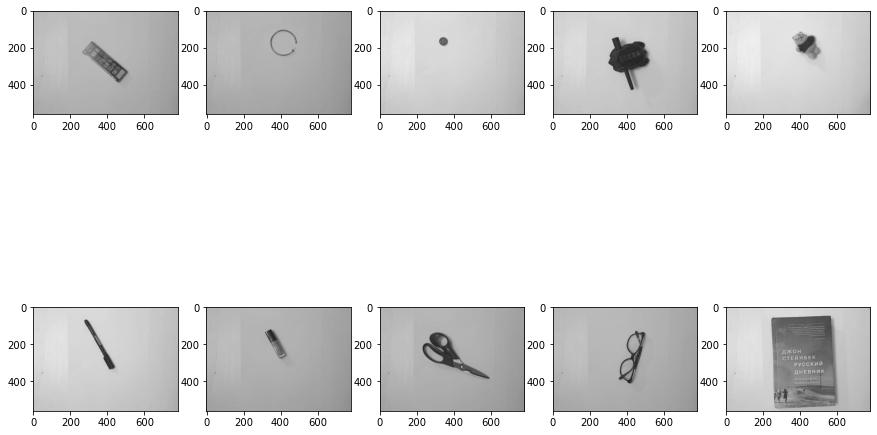

In [3]:
collection_p = 'images/patterns/*.jpg'
raw_templates = imread_collection(collection_p)
unchanged_templates = []
templates = []
for image in raw_templates:
    templates.append(rgb2gray(image))
    unchanged_templates.append(rgb2gray(image))
fig, ax = plt.subplots(2, 5, figsize=(15, 10))
height = [390, 950] #обрезаем так, чтобы размер фотографии был такой же, как у прямоугольников
width = [25, 805]
for i in range(10):
    templates[i] = templates[i][height[0]:height[1], width[0]:width[1]]
    ax[i % 2][i % 5].imshow(templates[i], cmap="gray")

Обрезали фотографии. Видно, что он все целиком влезают в окно.

Теперь выделим границы. По-хорошему, надо немного подкорректировать тень, но в принципе она не сильно мешает. 

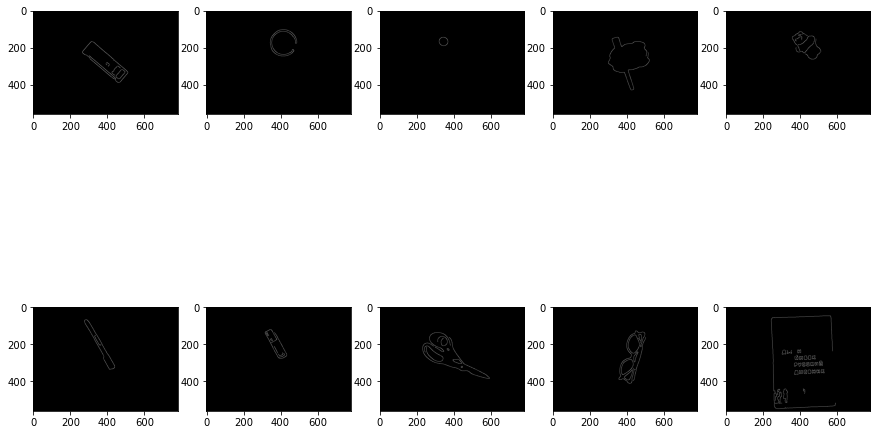

In [38]:
edges = []
fig, ax = plt.subplots(2, 5, figsize=(15, 10))
for i in range(10):
    edge = canny(templates[i], sigma=2.9)
    edges.append(np.stack(np.nonzero(edge), axis = 1))
    ax[i % 2][i % 5].imshow(edge, cmap="gray")
plt.savefig('edges.png', dpi=150)

Построим по границам выпуклые оболочки.
По картинкам видно, что они правда построились как надо. К сожалению, из-за разного раазмера предметов картинки слегка поехали, но вообще все в порядке.

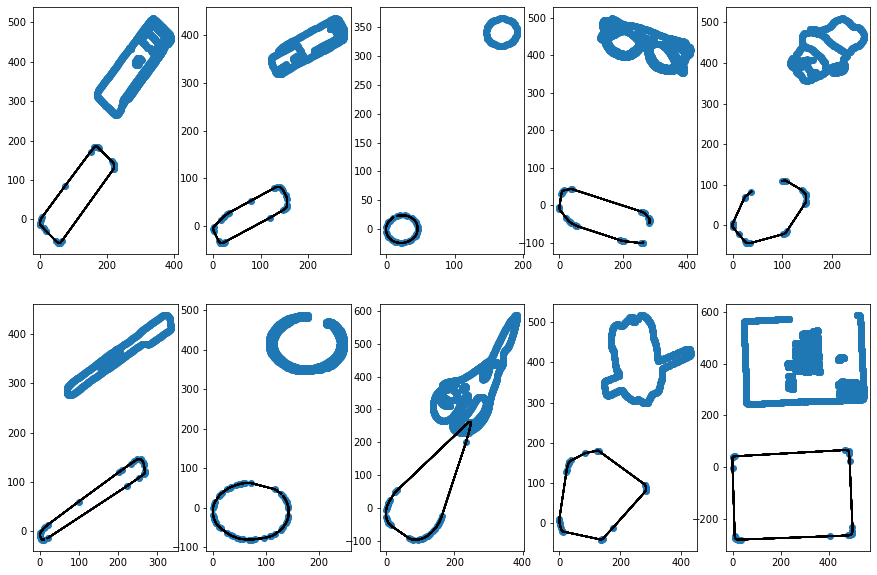

<Figure size 432x288 with 0 Axes>

In [39]:
template_hulls = []
fig, ax = plt.subplots(2, 5, figsize=(15, 10))
for i in range(10):
    points = edges[i]
    hull = ConvexHull(points)
    #Следующая строчка нужна, чтобы оболочки содержали начало координат. Это нужно для геометрической части
    points[hull.vertices] -= np.min(points[hull.vertices][:, 0]), points[np.argmin(points[hull.vertices][:, 0]), 1]
    template_hulls.append(points[hull.vertices])
    ax[i // 5][i % 5].plot(points[:,0], points[:,1], 'o')

    for simplex in hull.simplices:
    
        ax[i // 5][i % 5].plot(points[hull.vertices, 0], points[hull.vertices, 1], 'k-')

plt.show()
plt.savefig('convex-hulls.png', dpi=150)

In [6]:
collection_i = 'images/train/*.jpg'
raw_images = imread_collection(collection_i)
images = []

for image in raw_images:
    images.append(rgb2gray(image))

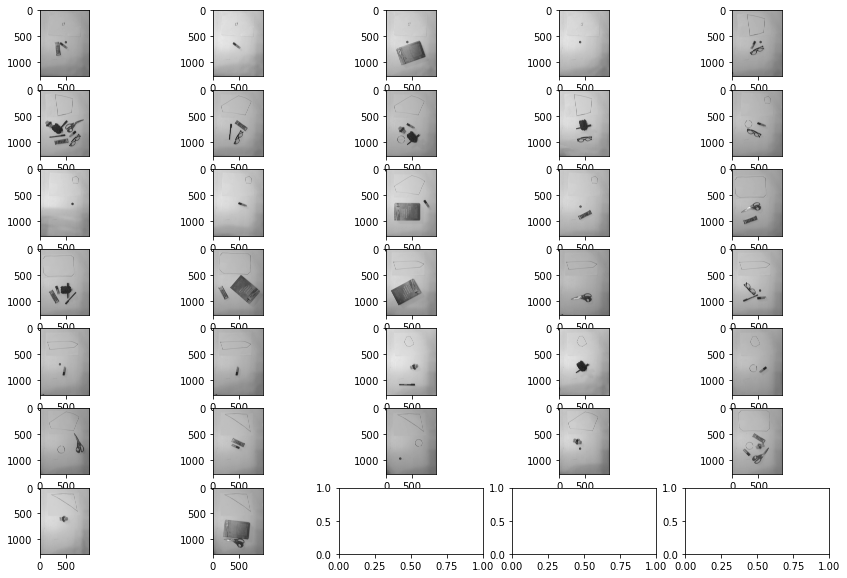

In [7]:

N = (len(images) + 4) // 5
fig, ax = plt.subplots(N, 5, figsize=(15, 10))
for i in range(len(images)):
    ax[i // 5][i % 5].imshow(images[i], cmap="gray")

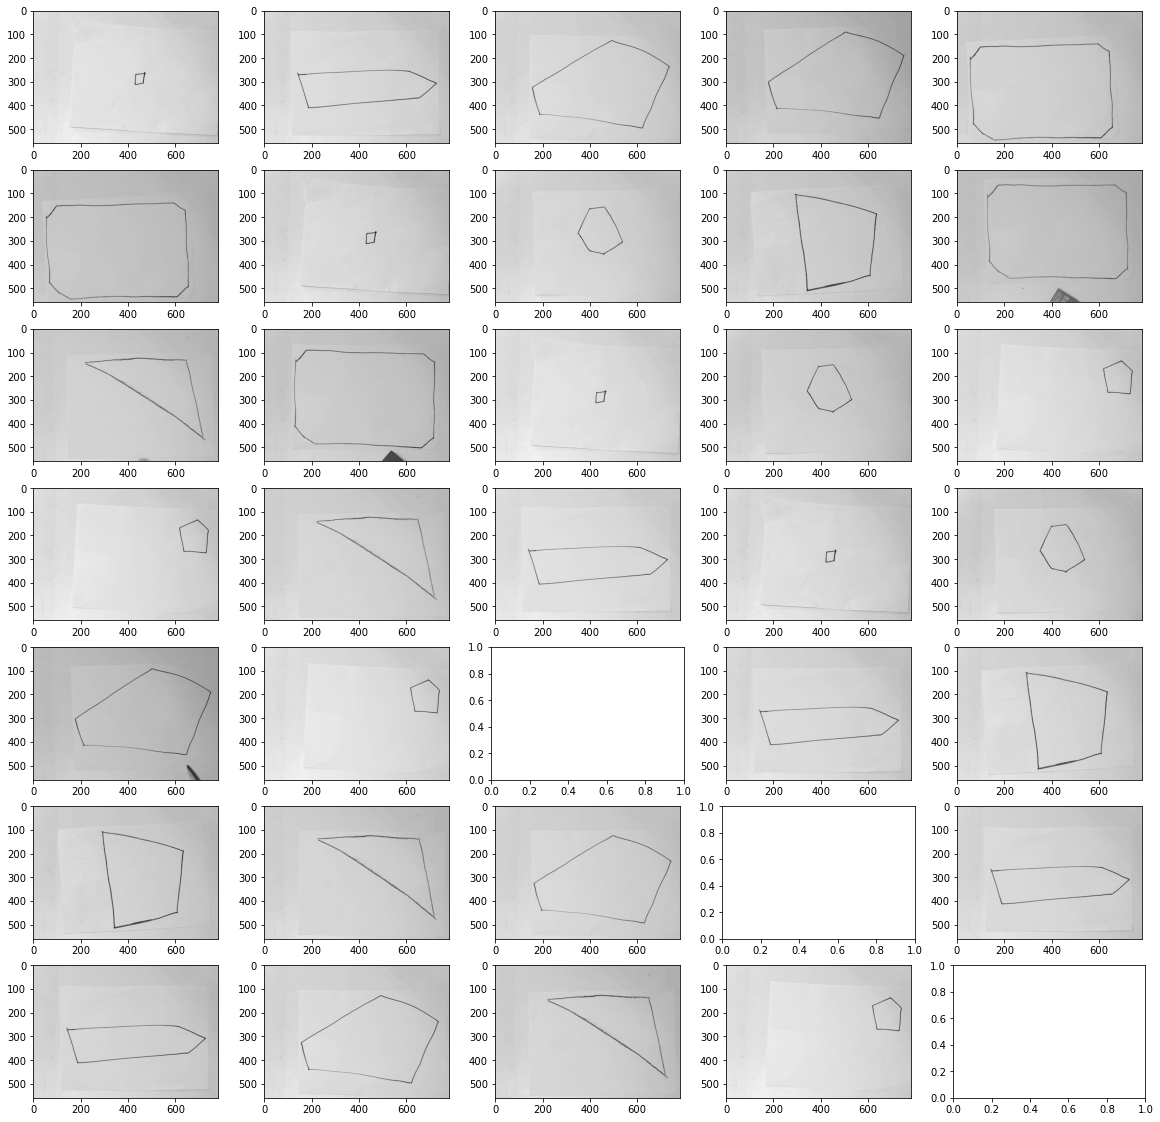

In [8]:
raw_polygons = []
objects = []
image = images[0]
polygon_height = [0, 560]
polygon_width = [0, 780]
N = (len(images) + 4) // 5
fig, ax = plt.subplots(N, 5, figsize=(20, 20))
for i in range(len(images)):
    raw_polygons.append(images[i][polygon_height[0]:polygon_height[1], polygon_width[0]:polygon_width[1]])
    objects.append(images[i][560:1100, 50:850])
    ax[i % N][i % 5].imshow(raw_polygons[i], cmap="gray")


Видно, что у некоторых полигонов теперь торчат снизу куски предметов. Выделим границы на фотографиях, замкнем границы морфологическими операциями, чтобы на изображении было ровно столько компонент связности, сколько на нем предеметов/многоугольников. Так как предметы могут появиться только снизу, достаточно выбрать первую компоненту связности.

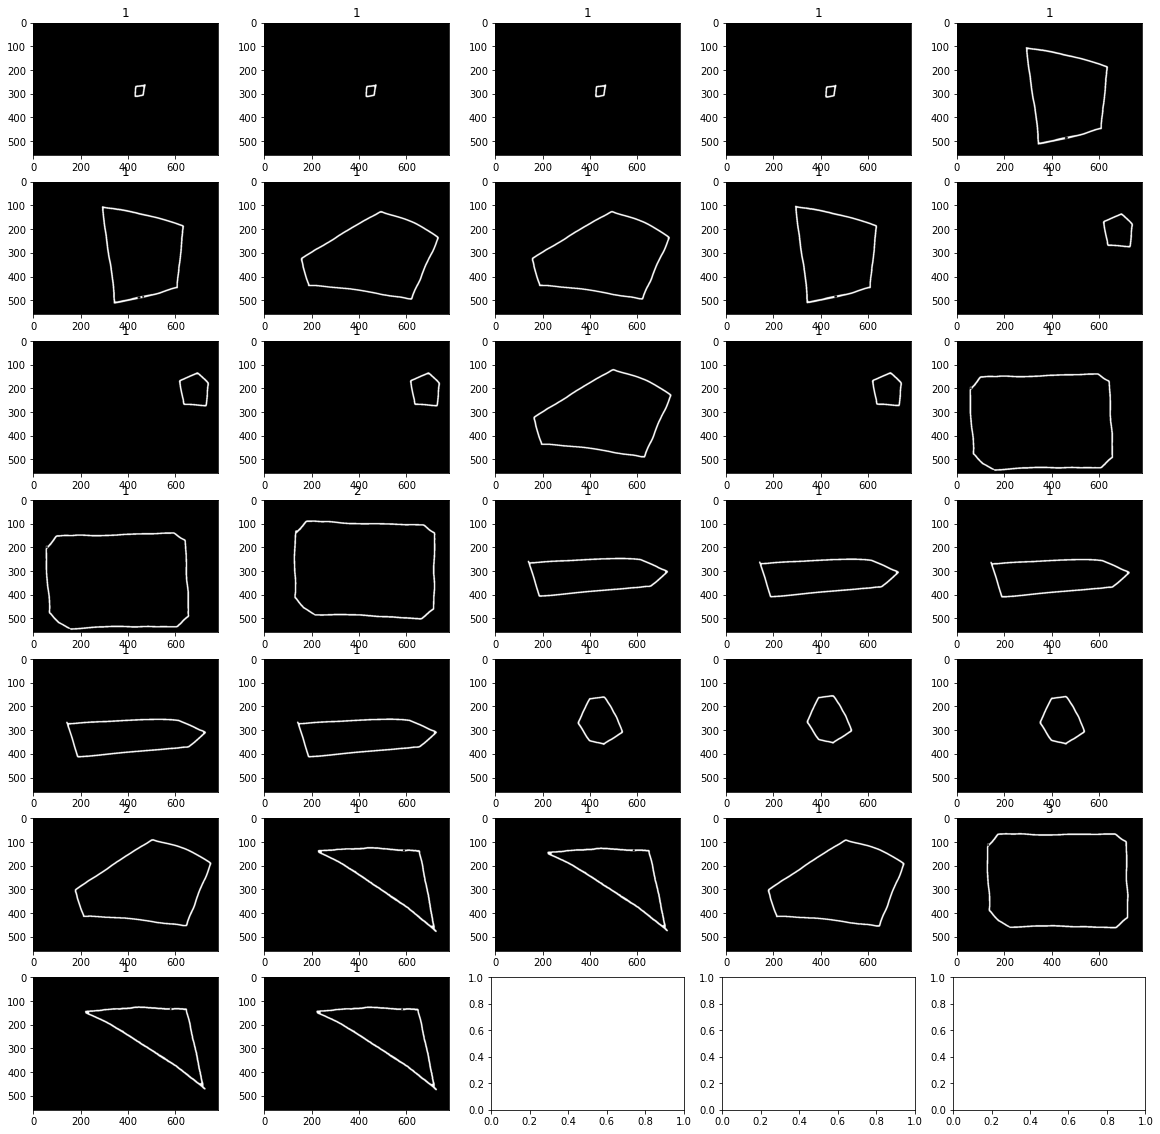

In [9]:
fig, ax = plt.subplots(N, 5, figsize=(20, 20))
polygons = []
for i in range(len(images)):
    edge = binary_closing(canny(raw_polygons[i], sigma = 2.5), np.ones((7, 7)))
    labels, num = sk_label(edge, return_num = True)
    polygons.append(np.stack(np.nonzero(np.where(labels == 1, edge, 0)), axis = 1))
    ax[i // 5][i % 5].set_title(num)
    ax[i // 5][i % 5].imshow(np.where(labels == 1, edge, 0), cmap="gray")

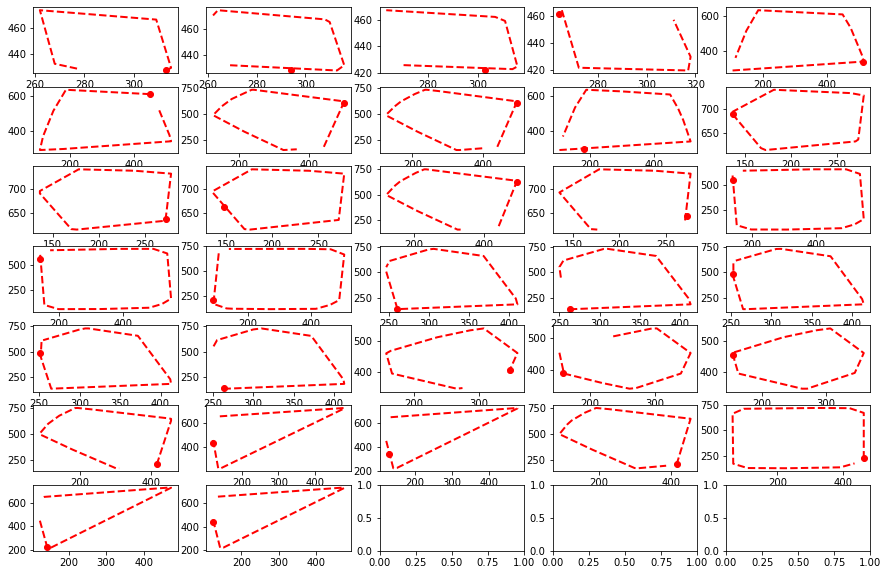

In [10]:
polygon_hulls = []
fig, ax = plt.subplots(N, 5, figsize=(15, 10))
ax.set_aspect('equal', adjustable='box')
for i in range(len(images)):
    points = polygons[i]
    hull = ConvexHull(points)
    new_polygon = np.array(pyclipper.CleanPolygon(points[hull.vertices]))
    polygon_hulls.append(new_polygon)
    ax[i // 5][i % 5].plot(new_polygon[:, 0], new_polygon[:, 1], 'r--', lw=2)


plt.show()

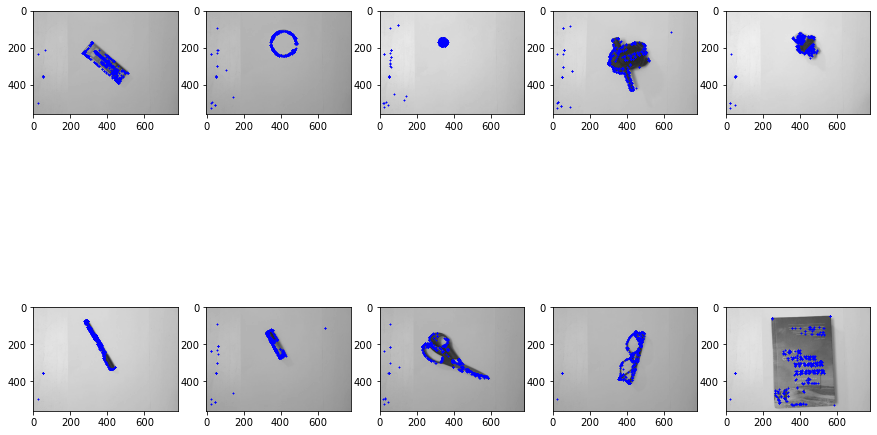

In [11]:
template_descriptors = []
template_keypoints = []
fig, ax = plt.subplots(2, 5, figsize=(15, 10))
for i in range(10):
    orb = ORB(harris_k = 0.001)
    orb.detect_and_extract(templates[i])
    descriptor = orb.descriptors
    template_descriptors.append(descriptor)
    template_keypoints.append(orb.keypoints)
    ax[i % 2][i % 5].imshow(templates[i], cmap="gray")
    ax[i % 2][i % 5].plot(orb.keypoints[:, 1], orb.keypoints[:, 0], '+b', markersize=2)

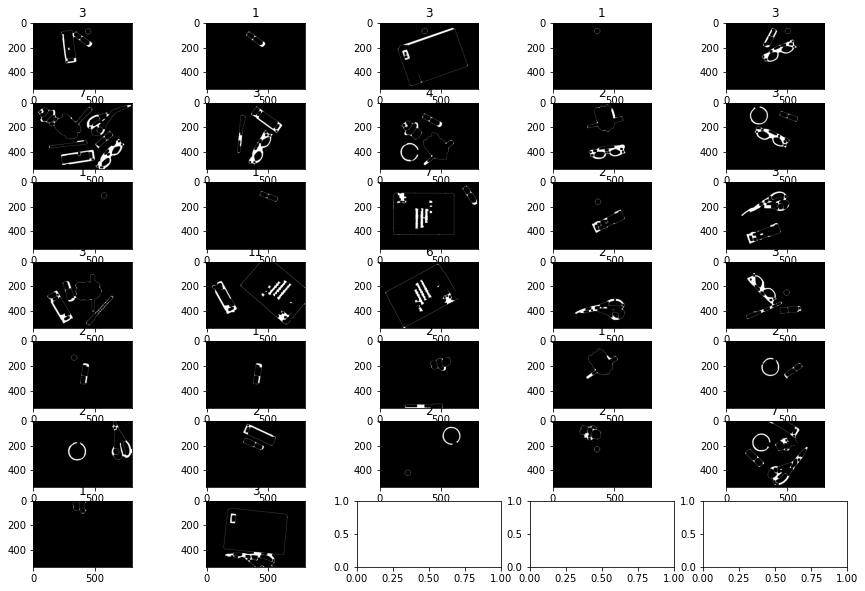

In [12]:
fig, ax = plt.subplots(N, 5, figsize=(15, 10))
binary_objects = []
nums = []
for i in range(len(objects)):
    edge = binary_closing(canny(objects[i], sigma = 3), np.ones((15, 15)))
    labels, num = sk_label(edge, return_num = True)
    binary_objects.append(labels)
    nums.append(num) #количество компонент связности, т.е предметов(с книгой не очень работает)
    ax[i // 5][i % 5].set_title(num)
    ax[i // 5][i % 5].imshow(edge, cmap="gray")

Найдем предметы на картинке. Функция detect_objects ищет для картинки количество соответствий особых точек с каждым шаблоном. Потом этот массив сортируется по убыванию количества соответствий. Функция возвращает k первых предметов, где k --- количество компонент связности на картинке. Работает это очень не точно, но первый предмет обычно находится правильно. Для фотографий с книгой не работает, потому что она разбивается на несколько компонент связности из-за текста.

In [15]:

def detect_objects(image, num_of_obj):
    a = [[0, i] for i in range(10)]
    for i in range(10):
        orb = ORB()
        orb.detect_and_extract(image)
        descriptor = orb.descriptors
        matches = match_descriptors(template_descriptors[i], descriptor, cross_check = True)
        src = template_keypoints[i][matches[:, 0]]
        dst = orb.keypoints[matches[:, 1]]
        estimated_transform, inliers = ransac((src, dst), AffineTransform, min_samples=3,
                                   residual_threshold=2, max_trials=1000)
        a[i][0] += np.where(inliers == True, 1, 0).sum()
    a.sort(key=lambda x: x[0])
    a.reverse()
    return np.array(a)[:num_of_obj, 1]

In [18]:
detected_objects = []
for i in range(32):
    detected_objects.append(detect_objects(objects[i], nums[i]))

Посмотрим, как оно работает. Работает не очень, но что-то определяет:

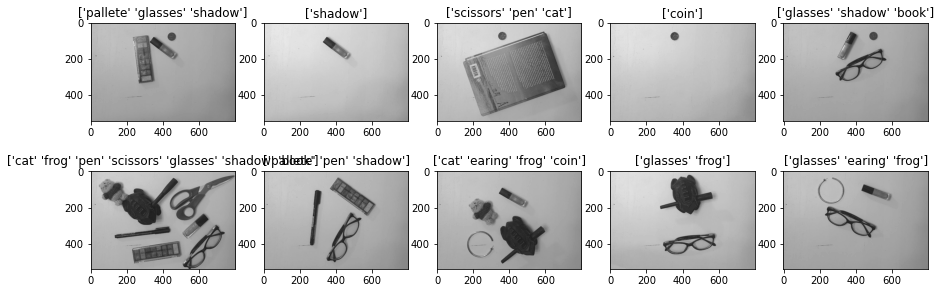

In [27]:
fig, ax = plt.subplots(2, 5, figsize=(15, 5))
for i in range(10):
    ax[i // 5][i % 5].set_title(str(template_names[detected_objects[i]]))
    ax[i // 5][i % 5].imshow(objects[i], cmap="gray")

По идее функция работает так:
    Берется разница минковского многоугольника и шаблона, из нее вычитается (как множество) многоугольник. 
    Если получившееся множество пустое -- ответ нет
    Иначе: "перемещаем" шаблон так, чтобы его самая левая точка совпадала с самой левой точкой получившегося множества. Вычитаем перемещенный шаблон из многоугольника (как множество), получаем (кажется?) многоугольник без дырок посередине. Выполняем первый шаг для следующего шаблона и нового многоугольника.
    
 Проблемы: очень долго + при операциях с многоугольниками появляются какие-то артефакты, которые мешают нормальной работе

In [112]:
def can_fit(polygon, detected_objects):
    n = len(detected_objects)
    for i in range(n):
        j = detected_objects[i]
        mink_diff = pyclipper.MinkowskiDiff(template_hulls[j], polygon)
        c = pyclipper.Pyclipper()
        if len(mink_diff) == 1:
            c.AddPath(mink_diff[0], pyclipper.PT_CLIP, True)
        else:
            c.AddPaths(mink_diff, pyclipper.PT_CLIP, True)
        c.AddPath(polygon, pyclipper.PT_SUBJECT, True)
        solution = c.Execute(pyclipper.CT_DIFFERENCE)
        #избавляемся от артефактов (хотя можем случайно и нормальные точки пропустить)
        #for k in range(len(solution)):
         #   if pyclipper.Area(solution[k]) / pyclipper.Area(polygon) < 0.01:
          #      solution.pop(k)
        if len(solution) == 0:
            return 0
        if i == n - 1:
            return 1
        x = np.array(solution[0])
        point = np.min(x[:, 0]), x[np.argmin(x[:, 0])][0]
        hole = template_hulls[j] + point
        c = pyclipper.Pyclipper()
        c.AddPath(hole, pyclipper.PT_CLIP, True)
        c.AddPath(polygon, pyclipper.PT_SUBJECT, True)
        polygon = c.Execute(pyclipper.CT_DIFFERENCE)[0]
    return 1
         
        
        
        

In [114]:
answers = []
for i in range(len(objects)):
    answers.append(can_fit(polygon_hulls[i], detected_objects[i]))
answers

[1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1]

Проверим процент правильных ответов. Получили 0.65, лучше, чем случайно или всегда да (выборка почти сбалансированная, 17 да, 15 нет). Можно, конечно, и лучше.

In [135]:
df = pd.read_csv('images.csv')
value = df.iloc[:, 1].to_numpy()
np.sum(np.array(answers) == value) / 32

0.65625

In [137]:
np.sum(value) / 32

0.53125